In [13]:
# 판다스와 넘파이
import pandas as pd
import numpy as np

# 이미지
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#머신러닝
import lightgbm as lgb
from lightgbm import LGBMRegressor

# 검증 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 기타
from tqdm import tqdm
import warnings ; warnings.filterwarnings('ignore')

#plt.rcParams['font.family'] = 'NanumBarunGothic'
#%config inlinebackend.figure_format = 'retina'
#plt.rcParams['figure.dpi'] = 100 

## 1. 데이터 전처리

In [14]:
#path = r'C:\Users\USER\Downloads\goblock\머신러닝 심화\'

#train = pd.read_csv(path + 'train.csv', encoding='cp949')
#train['date_time'] = pd.to_datetime(train['date_time'])
#test = pd.read_csv(path + 'test.csv', encoding='cp949')
#test['date_time'] = pd.to_datetime(test['date_time'])

train = pd.read_csv(r'C:\Users\USER\Downloads\goblock\머신러닝 심화\train.csv', encoding='cp949')
train['date_time'] = pd.to_datetime(train['date_time'])
test = pd.read_csv('test.csv', encoding='cp949')
test['date_time'] = pd.to_datetime(test['date_time'])

sample_submission = pd.read_csv('sample_submission.csv', encoding='cp949')

In [19]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21:00:00,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
train.info()
print('=' * 50)
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   num         122400 non-null  int64         
 1   date_time   122400 non-null  datetime64[ns]
 2   전력사용량(kWh)  122400 non-null  float64       
 3   기온(°C)      122400 non-null  float64       
 4   풍속(m/s)     122400 non-null  float64       
 5   습도(%)       122400 non-null  float64       
 6   강수량(mm)     122400 non-null  float64       
 7   일조(hr)      122400 non-null  float64       
 8   비전기냉방설비운영   122400 non-null  float64       
 9   태양광보유       122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [21]:
test.info()
print('=' * 50)
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   num           10080 non-null  int64         
 1   date_time     10080 non-null  datetime64[ns]
 2   기온(°C)        3360 non-null   float64       
 3   풍속(m/s)       3360 non-null   float64       
 4   습도(%)         3360 non-null   float64       
 5   강수량(mm, 6시간)  1680 non-null   float64       
 6   일조(hr, 3시간)   3360 non-null   float64       
 7   비전기냉방설비운영     2296 non-null   float64       
 8   태양광보유         1624 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 708.9 KB


num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

### 1-1. 결측치 처리

- train 데이터의 기간동안 비전기냉방설운영 형태나 태양광보유 상황이 달라지지 않은 것으로 보여, 현재의 값들로 test 데이터의 Null값을 채웁니다.
- 기온/풍속/습도/강수령/일조데이터는 선형보간으로 값을 채웁니다.

In [22]:
train.drop_duplicates(subset = ['num', '비전기냉방설비운영', '태양광보유']).dropna()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
2040,2,2020-06-01,977.184,18.3,2.5,94.0,0.0,0.0,1.0,0.0
4080,3,2020-06-01,3183.624,17.0,2.0,100.0,1.1,0.0,1.0,1.0
6120,4,2020-06-01,339.552,22.6,0.7,62.0,0.0,0.0,1.0,1.0
8160,5,2020-06-01,3063.744,18.3,2.5,94.0,0.0,0.0,1.0,0.0
10200,6,2020-06-01,527.580,17.0,2.0,100.0,1.1,0.0,0.0,0.0
12240,7,2020-06-01,1313.658,17.6,2.5,92.0,0.8,0.0,1.0,0.0
14280,8,2020-06-01,4801.977,19.1,1.1,73.0,0.0,0.0,1.0,1.0
16320,9,2020-06-01,1255.932,20.3,1.1,74.0,0.0,0.0,0.0,1.0
18360,10,2020-06-01,417.960,18.3,2.5,94.0,0.0,0.0,1.0,0.0


In [10]:
train['num'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64)

In [25]:
train.head(20)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0
6,1,2020-06-01 06:00:00,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0
7,1,2020-06-01 07:00:00,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0
8,1,2020-06-01 08:00:00,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0
9,1,2020-06-01 09:00:00,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0


In [12]:
test.head(20)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,2020-08-25 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,2020-08-25 06:00:00,26.1,1.3,83.0,0.0,0.0,NaN,NaN
7,1,2020-08-25 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,2020-08-25 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,2020-08-25 09:00:00,28.8,1.2,77.0,NaN,1.1,NaN,NaN


In [23]:
sun = train.groupby('num')['태양광보유'].unique()
non_ele = train.groupby('num')['비전기냉방설비운영'].unique()

In [27]:
i = 0
train.loc[train['num']==(i+1), '태양광보유'].unique()

array([0.])

In [ ]:
for i in range(60):
    test.loc[test['num']==(i+1), '태양광보유'] = train.loc[train['num']==(i+1), '태양광보유'].unique()

In [28]:
test['태양광보유'] = test['num'].map(sun).astype(int)
test['비전기냉방설비운영'] = test['num'].map(non_ele).astype(int)

In [29]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,0,0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,0,0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,0,0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,0,0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,NaN,NaN,NaN,NaN,NaN,1,1
10076,60,2020-08-31 20:00:00,NaN,NaN,NaN,NaN,NaN,1,1
10077,60,2020-08-31 21:00:00,27.9,4.1,68.0,NaN,0.0,1,1
10078,60,2020-08-31 22:00:00,NaN,NaN,NaN,NaN,NaN,1,1


In [30]:
test = test.interpolate()
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0,0
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0,0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0,0
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.0,0,0


### 1-2. feature engineering

In [31]:
# date_time에서 요일과 시간 추출
train['weekday'] = train['date_time'].dt.weekday + 1
train['hour'] = train['date_time'].dt.hour

test['weekday'] = test['date_time'].dt.weekday + 1
test['hour'] = test['date_time'].dt.hour

In [32]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,weekday,hour
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,1
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,1,19
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,1,20
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,1,21
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,1,22


In [33]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,weekday,hour
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.000000,0,0,2,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.000000,0,0,2,1
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.000000,0,0,2,2
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.000000,0,0,2,3
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.000000,0,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,28.633333,3.566667,66.000000,0.0,0.533333,1,1,1,19
10076,60,2020-08-31 20:00:00,28.266667,3.833333,67.000000,0.0,0.266667,1,1,1,20
10077,60,2020-08-31 21:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1,1,1,21
10078,60,2020-08-31 22:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1,1,1,22


- 전력사용 패턴에 따른 건물별 clustering의 아이디어는 
[세아아부지](https://dacon.io/competitions/official/235736/codeshare/2643?page=1&dtype=recent)님의 Analytics를 참고했습니다.

In [36]:
from sklearn.cluster import k_means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

d_list = []
for i in range(1, 61):
    d = train[train['num'] == i].copy()
    d['전력사용량(kWh)'] = scaler.fit_transform(d['전력사용량(kWh)'].values.reshape(-1,1))
    d_ = d.groupby(['weekday', 'hour'])['전력사용량(kWh)'].mean().unstack()
    d_list.append(d_.to_numpy())

# 정규화된 시간-요일별 전력사용량을 이미지처럼 저장
d_list = np.array(d_list)

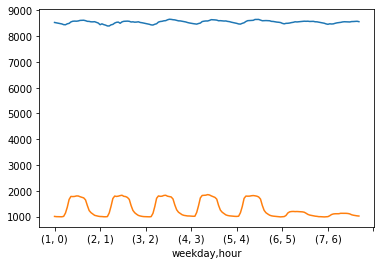

In [41]:
i =1
train[train['num'] == i].groupby(['weekday', 'hour'])['전력사용량(kWh)'].mean().plot()
train[train['num'] == i+1].groupby(['weekday', 'hour'])['전력사용량(kWh)'].mean().plot()

In [43]:
d_list_ = d_list.reshape(60, -1)
model = KMeans(init="k-means++", n_clusters=4, random_state=0)
model.fit(d_list_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [59]:
pd.DataFrame(cluster)[0]

0     0
1     1
2     0
3     2
4     0
5     1
6     1
7     1
8     0
9     2
10    2
11    2
12    1
13    1
14    0
15    1
16    1
17    1
18    3
19    3
20    3
21    1
22    1
23    1
24    1
25    1
26    1
27    2
28    2
29    2
30    2
31    2
32    1
33    3
34    1
35    2
36    1
37    2
38    2
39    2
40    2
41    2
42    1
43    1
44    1
45    1
46    1
47    1
48    3
49    3
50    3
51    1
52    1
53    1
54    1
55    1
56    1
57    1
58    2
59    2
Name: 0, dtype: int32

In [48]:
cluster = model.labels_
pd.DataFrame(cluster)[0].value_counts()

1    31
2    17
3     7
0     5
Name: 0, dtype: int64

- K-means 군집화로 60개 건물의 시간-요일별 전력사용량 이미지를 4개로 분류했습니다.

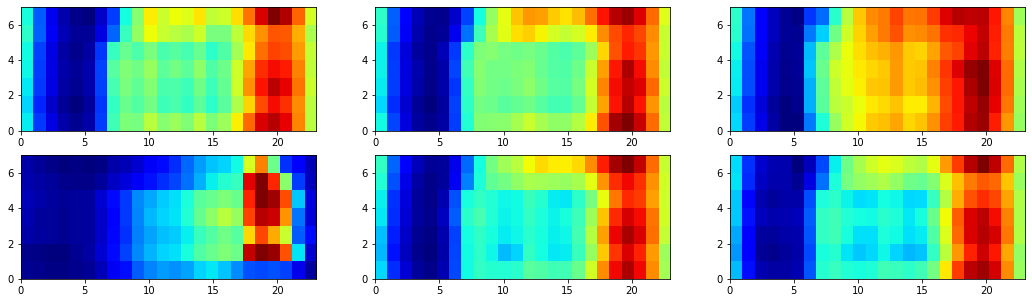

In [53]:
idx = cluster == 3
d_list = d_list.reshape(60, 7, 24)


fig, axes = plt.subplots(2, int(len(d_list[idx])/2), figsize = (18, 5))
axes = axes.flatten()

for d, ax in zip(d_list[idx], axes):
    d_ = scaler.inverse_transform(d)
    
    ax.imshow(d_, cmap = 'jet', aspect = 'auto', extent=[0, 23, 0, 7], origin = 'lower')

In [55]:
cluster_map = {i+1 : c for i, c in enumerate(cluster)}
train['cluster'] = train['num'].map(cluster_map)
test['cluster'] = test['num'].map(cluster_map)

In [58]:
cluster_map

{1: 0,
 2: 1,
 3: 0,
 4: 2,
 5: 0,
 6: 1,
 7: 1,
 8: 1,
 9: 0,
 10: 2,
 11: 2,
 12: 2,
 13: 1,
 14: 1,
 15: 0,
 16: 1,
 17: 1,
 18: 1,
 19: 3,
 20: 3,
 21: 3,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 2,
 29: 2,
 30: 2,
 31: 2,
 32: 2,
 33: 1,
 34: 3,
 35: 1,
 36: 2,
 37: 1,
 38: 2,
 39: 2,
 40: 2,
 41: 2,
 42: 2,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 3,
 50: 3,
 51: 3,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 2,
 60: 2}

In [66]:
i=3
train[train['num']==i][['cluster']]

,cluster
4080,0
4081,0
4082,0
4083,0
4084,0
...,...
6115,0
6116,0
6117,0
6118,0


In [57]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,weekday,hour,cluster
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.000000,0,0,2,0,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.000000,0,0,2,1,0
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.000000,0,0,2,2,0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.000000,0,0,2,3,0
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.000000,0,0,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,28.633333,3.566667,66.000000,0.0,0.533333,1,1,1,19,2
10076,60,2020-08-31 20:00:00,28.266667,3.833333,67.000000,0.0,0.266667,1,1,1,20,2
10077,60,2020-08-31 21:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1,1,1,21,2
10078,60,2020-08-31 22:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1,1,1,22,2


In [84]:
train.columns

Index(['num', 'date_time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)',
       '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유', 'weekday', 'hour',
       'cluster'],
      dtype='object')

In [86]:
test.columns

Index(['num', 'date_time', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm, 6시간)',
       '일조(hr, 3시간)', '비전기냉방설비운영', '태양광보유', 'weekday', 'hour', 'cluster'],
      dtype='object')

In [89]:
train.columns = ['num', 'date_time', 'consumption', 'temp', 'wind', 'humidity',
                 'precipitation', 'sunshine', 'non-cooling system', 'solar cell', 'weekday', 'hour',
                 'cluster']

test.columns = ['num', 'date_time', 'temp', 'wind', 'humidity', 
                'precipitation','sunshine', 'non-cooling system', 'solar cell', 'weekday', 'hour', 
                'cluster']

In [90]:
train.head()

,num,date_time,consumption,temp,wind,humidity,precipitation,sunshine,non-cooling system,solar cell,weekday,hour,cluster
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,0,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,1,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,2,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,3,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,4,0


In [91]:
test.head()

,num,date_time,temp,wind,humidity,precipitation,sunshine,non-cooling system,solar cell,weekday,hour,cluster
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0,0,2,0,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0,0,2,1,0
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0,0,2,2,0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0,0,2,3,0
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.0,0,0,2,4,0


In [95]:
column = ['num', 'date_time', 'temp', 'wind', 'humidity',
          'precipitation', 'sunshine', 'non-cooling system', 'solar cell', 'weekday', 'hour',
          'cluster', 'consumption']
train = train[column]
train.head()

,num,date_time,temp,wind,humidity,precipitation,sunshine,non-cooling system,solar cell,weekday,hour,cluster,consumption
0,1,2020-06-01 00:00:00,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,0,0,8179.056
1,1,2020-06-01 01:00:00,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,1,0,8135.640
2,1,2020-06-01 02:00:00,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,2,0,8107.128
3,1,2020-06-01 03:00:00,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,3,0,8048.808
4,1,2020-06-01 04:00:00,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,4,0,8043.624


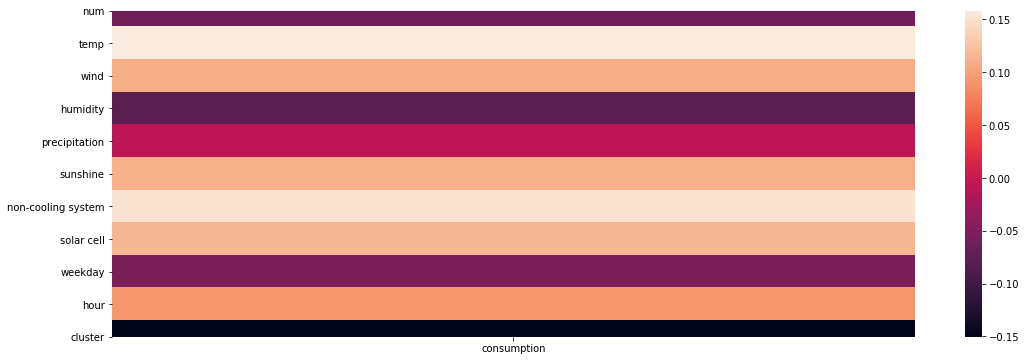

In [97]:
plt.figure(figsize=(18,6))
sns.heatmap(train.corr().loc['num':'cluster','consumption':'consumption'])

In [ ]:
# 불쾌지수 컬럼을 train, test 에 새컬럼으로 만들어보세요.


## 2. Modeling
- K-fold와 lgbm으로 모델을 구성합니다

In [69]:
X = train.drop(['date_time', '전력사용량(kWh)'], axis = 1)
y = train['전력사용량(kWh)']
X_test = test.drop('date_time', axis = 1)

In [70]:
X.head()

,num,기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,weekday,hour,cluster
0,1,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,0,0
1,1,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,1,0
2,1,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,2,0
3,1,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,3,0
4,1,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,4,0


In [72]:
X_test

,num,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,weekday,hour,cluster
0,1,27.800000,1.500000,74.000000,0.0,0.000000,0,0,2,0,0
1,1,27.633333,1.366667,75.333333,0.0,0.000000,0,0,2,1,0
2,1,27.466667,1.233333,76.666667,0.0,0.000000,0,0,2,2,0
3,1,27.300000,1.100000,78.000000,0.0,0.000000,0,0,2,3,0
4,1,26.900000,1.166667,79.666667,0.0,0.000000,0,0,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...
10075,60,28.633333,3.566667,66.000000,0.0,0.533333,1,1,1,19,2
10076,60,28.266667,3.833333,67.000000,0.0,0.266667,1,1,1,20,2
10077,60,27.900000,4.100000,68.000000,0.0,0.000000,1,1,1,21,2
10078,60,27.900000,4.100000,68.000000,0.0,0.000000,1,1,1,22,2


In [83]:
#from sklearn.model_selection import train_test_split
#from lightgbm import LGBMRegressor
#from sklearn.model_selection import StratifiedKFold

n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)

y_pred = np.zeros(len(X_test))
result = 0

# train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
for tr_idx, val_idx in sfk.split(X, X['num']):      
    X_train = X.iloc[tr_idx, :]
    y_train = y[tr_idx]

    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]

    lgbm = LGBMRegressor(n_estimators = 10000, learning_rate= 0.1,objective = 'mse') # mse : mean squared error
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds= 50,verbose = 500)
    y_pred += lgbm.predict(X_test) / n_splits
    
    # (296.634+220.068+241.773+241.773+239.757+381.939)/5
    # 위의 결과값들의 평균을 계산하는 코드를 아래에 작성해보세요.
    val_pred = lgbm.predict(X_val)
    
    #result += np.mean(np.sqrt(np.square(y_val-val_pred))) / n_splits
    
    # smape 식으로 result를 도출해보세요.

    #result += np.mean((np.abs(y_val-val_pred))/(np.abs(y_val) + np.abs(val_pred))) / n_splits
    result += (np.mean(np.abs(y_val-val_pred)/(np.abs(y_val)+np.abs(val_pred)))*100) / n_splits
   
    print(result)
    

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 305.709
[1000]	valid_0's rmse: 297.945
Early stopping, best iteration is:
[1248]	valid_0's rmse: 296.634
0.8719833105162648
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 227.496
Early stopping, best iteration is:
[943]	valid_0's rmse: 220.068
1.6005680480803641
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 252.201
[1000]	valid_0's rmse: 243.728
Early stopping, best iteration is:
[1351]	valid_0's rmse: 241.773
2.3269243375517252
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 247.169
[1000]	valid_0's rmse: 239.996
Early stopping, best iteration is:
[1067]	valid_0's rmse: 239.757
3.0940192523909404
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 400.296
[1000]	valid_0's rmse: 387.286
[1500]	valid_0's rmse: 383.107
Early stopping, best iteration is:
[1827]	vali

In [ ]:
# default 4.070423351505301

In [77]:
(296.634+220.068+241.773+241.773+239.757+381.939)/5

324.38880000000006

In [86]:
submission = sample_submission.copy()
submission['answer'] = y_pred

In [ ]:
submission.to_csv('전력사용량_baseline_lgbm.csv', index= False)